In [ ]:
# !pip3 install torch torchvision

In [20]:
# %matplotlib inline
import os
from torch import nn
import torchvision.models as models
import torch.nn.functional as F


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
# from sklearn.preprocessing import QuantileTransformer

## Preparing data

In [4]:
import importlib
import DataUtils.data_loader
importlib.reload(DataUtils.data_loader)
from DataUtils.data_loader import CustomDataset
from torchvision.transforms import transforms


train_set = CustomDataset("train")#, transforms=augmentations)
test_set = CustomDataset("test")
test_set, val_set = torch.utils.data.random_split(test_set, [0.5, 0.5])

In [ ]:
# Creating data loaders for the train, validation and tesimg splits
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

## Training algoritihm

In [6]:

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [9]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model = model.float()
    for epoch in range(num_epochs):

        model.train()
        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)
            preds = F.one_hot(preds)
            
            if(preds.shape != labels.shape):
                preds = F.pad(input=preds, pad=(0, 1), mode='constant', value=0)
            loss = criterion(outputs, labels)
            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()
            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)/4
        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_set)
        train_acc = running_corrects.to(torch.float32) / len(train_set)


        # Set model to evaluation mode
        model.eval()
        model = model.float()
        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.float().to(device)
                # Forward pass
                outputs = model(inputs.float())
                _, preds = torch.max(outputs, 1)
                preds = torch.nn.functional.one_hot(preds)
                loss = criterion(outputs, labels)

                if(preds.shape != labels.shape):
                    preds = F.pad(input=preds, pad=(0, 1), mode='constant', value=0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)/4
        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_set)
        val_acc = running_corrects.to(torch.float32) / len(val_set)

        # Print the epoch results
        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))


## Fine tuning

In [ ]:
import torch
import torchvision.models as models

class ModelConfigurationService:
    @staticmethod    
    def get_pretrained_resnet18_configuration(lr, momentum):
        model = models.resnet18(pretrained=True)
    #freezing layers of pre-trained model so that i don't backpropagate through them
        for param in model.parameters():
            param.requires_grad = False
        num_classes = 4
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    # Defining the loss function and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.fc.parameters(), lr=lr, momentum=momentum)

        model.to(device)
        return model,criterion,optimizer
    
    @staticmethod
    def unfreeze_model_layers(model):
        for param in model.parameters():
            param.requires_grad = True
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        return optimizer
# Loading the pre-trained ResNet-18 model


model, criterion, optimizer = ModelConfigurationService.get_pretrained_resnet18_configuration(lr=0.001, momentum=0.9)

train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

optimizer = ModelConfigurationService.unfreeze_model_layers(model)

train(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)


In [12]:
def get_inedexes_of_max_values(list_of_one_hot):
    list_of_indices = [one_hot_line.index(max(one_hot_line)) for one_hot_line in list_of_one_hot.tolist()]
    return list_of_indices

test_labels = []
test_outputs = []

for images, labels in test_loader:

    images = images.to(device)
    label_classes = get_inedexes_of_max_values(labels.numpy())
    test_labels += label_classes
    labels = labels.float().to(device)
    outputs = model(images.float())
    _, predicted = torch.max(outputs, 1)
    predicted =  predicted.tolist()
    test_outputs += predicted

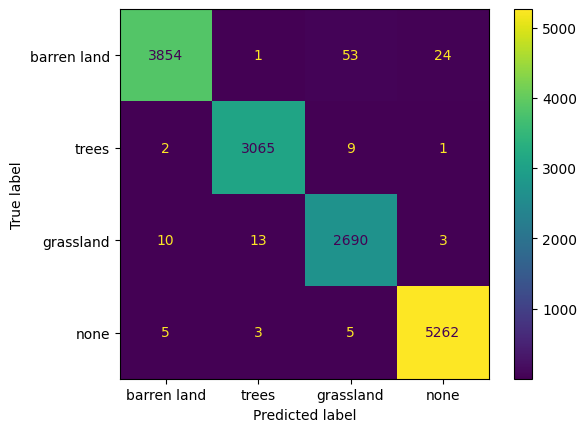

In [29]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_labels, test_outputs)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['barren land', 'trees', 'grassland', 'none'])

cm_display.plot()
plt.show() 
